In [1]:
import os
import pickle
import time
from collections import namedtuple
from datetime import datetime, timedelta

import pandas as pd
import requests

import matplotlib.pyplot as plt
from pyprind import ProgBar

%matplotlib inline

In [2]:
API_KEY = os.environ.get('MY_API_KEY')
BASE_URL = 'http://api.wunderground.com/api/{}/history_{}/q/TX/Round_Rock.json'

In [3]:
features = [
    "date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity",
    "minhumidity", "maxtempm", "mintempm", "maxdewptm", "mindewptm",
    "maxpressurem", "minpressurem", "precipm"
]
DailySummary = namedtuple('DailySummary', features)

In [4]:
def extract_weather_data(url, api_key, target_date, days):
    """Call Wunderground API to extract weather data."""
    records = []
    bar = ProgBar(days)
    for _ in range(days):
        request = BASE_URL.format(API_KEY, target_date.strftime('%Y%m%d'))
        response = requests.get(request)
        if response.status_code == 200:
            data = response.json()['history']['dailysummary'][0]
            records.append(DailySummary(
                date=target_date,
                meantempm=data['meantempm'],
                meandewptm=data['meandewptm'],
                meanpressurem=data['meanpressurem'],
                maxhumidity=data['maxhumidity'],
                minhumidity=data['minhumidity'],
                maxtempm=data['maxtempm'],
                mintempm=data['mintempm'],
                maxdewptm=data['maxdewptm'],
                mindewptm=data['mindewptm'],
                maxpressurem=data['maxpressurem'],
                minpressurem=data['minpressurem'],
                precipm=data['precipm']))
        time.sleep(6)
        bar.update()
        target_date += timedelta(days=1)
    return records

In [5]:
# Do not run this cell when collecting data on day 2
def get_target_date():
    """Return target date 1000 days prior to current date."""
    current_date = datetime.now()
    target_date = current_date - timedelta(days=1000)
    return target_date

target_date = get_target_date()

In [6]:
records = extract_weather_data(BASE_URL, API_KEY, target_date, 500)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:53:56


In [7]:
# Look at first five records
records[:5]

[DailySummary(date=datetime.datetime(2015, 10, 3, 22, 13, 6, 559948), meantempm='21', meandewptm='6', meanpressurem='1012', maxhumidity='63', minhumidity='20', maxtempm='29', mintempm='14', maxdewptm='8', mindewptm='4', maxpressurem='1014', minpressurem='1010', precipm='0.00'),
 DailySummary(date=datetime.datetime(2015, 10, 4, 22, 13, 6, 559948), meantempm='22', meandewptm='8', meanpressurem='1015', maxhumidity='63', minhumidity='25', maxtempm='29', mintempm='15', maxdewptm='10', mindewptm='7', maxpressurem='1017', minpressurem='1013', precipm='0.00'),
 DailySummary(date=datetime.datetime(2015, 10, 5, 22, 13, 6, 559948), meantempm='24', meandewptm='11', meanpressurem='1018', maxhumidity='64', minhumidity='35', maxtempm='29', mintempm='19', maxdewptm='13', mindewptm='8', maxpressurem='1020', minpressurem='1015', precipm='0.00'),
 DailySummary(date=datetime.datetime(2015, 10, 6, 22, 13, 6, 559948), meantempm='23', meandewptm='11', meanpressurem='1019', maxhumidity='73', minhumidity='25',

In [8]:
len(records)

500

In [9]:
# save records list
with open('records_pt1.pkl', 'wb') as f:
    pickle.dump(records, f)

In [5]:
# load records list - still need to run cells 1-4
with open('records_pt1.pkl', 'rb') as fp:
    records = pickle.load(fp)

In [6]:
# Inspect last record to date; next target date should be plus one day
records[-1]

DailySummary(date=datetime.datetime(2017, 2, 13, 22, 13, 6, 559948), meantempm='20', meandewptm='13', meanpressurem='1018', maxhumidity='94', minhumidity='42', maxtempm='25', mintempm='16', maxdewptm='18', mindewptm='5', maxpressurem='1022', minpressurem='1012', precipm='0.00')

In [7]:
# set new target date based on date above plus one day
target_date = datetime(2017, 2, 14)

In [8]:
records += extract_weather_data(BASE_URL, API_KEY, target_date, 500)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:53:38


In [9]:
len(records)

1000

In [10]:
# with open('records_pt2.pkl', 'wb') as f:
#     pickle.dump(records, f)

In [11]:
# load records list - still need to run cells 1 and 3
# with open('records_pt2.pkl', 'rb') as fp:
#     records = pickle.load(fp)

In [12]:
df = pd.DataFrame(records, columns=features).set_index('date')

In [13]:
tmp = df[['meantempm', 'meandewptm']].head(10)
tmp

,meantempm,meandewptm
date,,
2015-10-03 22:13:06.559948,21,6
2015-10-04 22:13:06.559948,22,8
2015-10-05 22:13:06.559948,24,11
2015-10-06 22:13:06.559948,23,11
2015-10-07 22:13:06.559948,24,13
2015-10-08 22:13:06.559948,26,17
2015-10-09 22:13:06.559948,26,17
2015-10-10 22:13:06.559948,24,14
2015-10-11 22:13:06.559948,26,16


In [14]:
# 1 day prior
N = 1

# target measurement of mean temperature
feature = 'meantempm'

# total number of rows
rows = tmp.shape[0]

# a list representing Nth prior measurements of feature
nth_prior_measurements = tmp[feature].shift(periods=N)

# makee a new column name of feature_N and add to DataFrame
col_name = f'{feature}_{N}'
tmp[col_name] = nth_prior_measurements
tmp

,meantempm,meandewptm,meantempm_1
date,,,
2015-10-03 22:13:06.559948,21,6,NaN
2015-10-04 22:13:06.559948,22,8,21
2015-10-05 22:13:06.559948,24,11,22
2015-10-06 22:13:06.559948,23,11,24
2015-10-07 22:13:06.559948,24,13,23
2015-10-08 22:13:06.559948,26,17,24
2015-10-09 22:13:06.559948,26,17,26
2015-10-10 22:13:06.559948,24,14,26
2015-10-11 22:13:06.559948,26,16,24


In [15]:
def derive_nth_day_feature(df, feature, N):
    nth_prior_measurements = df[feature].shift(periods=N)
    col_name = f'{feature}_{N}'
    df[col_name] = nth_prior_measurements

In [16]:
for feature in features:
    if feature != 'date':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [17]:
df.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

In [18]:
# make list of original features without meantempm, mintempm, and maxtempm
to_remove = [feature
             for feature in features
             if feature not in ['meantempm', 'mintempm', 'maxtempm']]

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

Index(['meantempm', 'maxtempm', 'mintempm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2015-10-03 22:13:06.559948 to 2018-06-28 00:00:00
Data columns (total 39 columns):
meantempm          1000 non-null object
maxtempm           1000 non-null object
mintempm           1000 non-null object
meantempm_1        999 non-null object
meantempm_2        998 non-null object
meantempm_3        997 non-null object
meandewptm_1       999 non-null object
meandewptm_2       998 non-null object
meandewptm_3       997 non-null object
meanpressurem_1    999 non-null object
meanpressurem_2    998 non-null object
meanpressurem_3    997 non-null object
maxhumidity_1      999 non-null object
maxhumidity_2      998 non-null object
maxhumidity_3      997 non-null object
minhumidity_1      999 non-null object
minhumidity_2      998 non-null object
minhumidity_3      997 non-null object
maxtempm_1         999 non-null object
maxtempm_2         998 non-null object
maxtempm_3         997 non-null object
mintempm_1         999 non-n

In [20]:
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2015-10-03 22:13:06.559948 to 2018-06-28 00:00:00
Data columns (total 39 columns):
meantempm          997 non-null float64
maxtempm           997 non-null float64
mintempm           997 non-null float64
meantempm_1        996 non-null float64
meantempm_2        995 non-null float64
meantempm_3        994 non-null float64
meandewptm_1       996 non-null float64
meandewptm_2       995 non-null float64
meandewptm_3       994 non-null float64
meanpressurem_1    994 non-null float64
meanpressurem_2    993 non-null float64
meanpressurem_3    992 non-null float64
maxhumidity_1      996 non-null float64
maxhumidity_2      995 non-null float64
maxhumidity_3      994 non-null float64
minhumidity_1      996 non-null float64
minhumidity_2      995 non-null float64
minhumidity_3      994 non-null float64
maxtempm_1         996 non-null float64
maxtempm_2         995 non-null float64
maxtempm_3         994 non-null float64
mintempm_1

In [21]:
# Call describe on df and transpose it due to the large number of columns
spread = df.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min'] <
                      (spread['25%'] -
                       (3 * IQR))) | (spread['max'] >
                                      (spread['75%'] + 3 * IQR))

# just display the features containing extreame outliers
spread.loc[spread.outliers, ]

,count,mean,std,min,25%,50%,75%,max,outliers
maxhumidity_1,996.0,94.326305,10.732047,45.0,94.0,100.0,100.0,100.00,True
maxhumidity_2,995.0,94.320603,10.735934,45.0,94.0,100.0,100.0,100.00,True
maxhumidity_3,994.0,94.314889,10.739825,45.0,94.0,100.0,100.0,100.00,True
minpressurem_1,994.0,1014.230382,5.858541,996.0,1011.0,1014.0,1017.0,1037.00,True
minpressurem_2,993.0,1014.231621,5.861363,996.0,1011.0,1014.0,1017.0,1037.00,True
minpressurem_3,992.0,1014.231855,5.864315,996.0,1011.0,1014.0,1017.0,1037.00,True
precipm_1,999.0,1.419109,7.958652,0.0,0.0,0.0,0.0,131.57,True
precipm_2,998.0,1.420531,7.962515,0.0,0.0,0.0,0.0,131.57,True
precipm_3,997.0,1.421956,7.966384,0.0,0.0,0.0,0.0,131.57,True


In [22]:
# iterate over the precip columns
for precip_col in ['precipm_1', 'precipm_2', 'precipm_3']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[precip_col])
    df[precip_col][missing_vals] = 0

In [23]:
df = df.dropna()

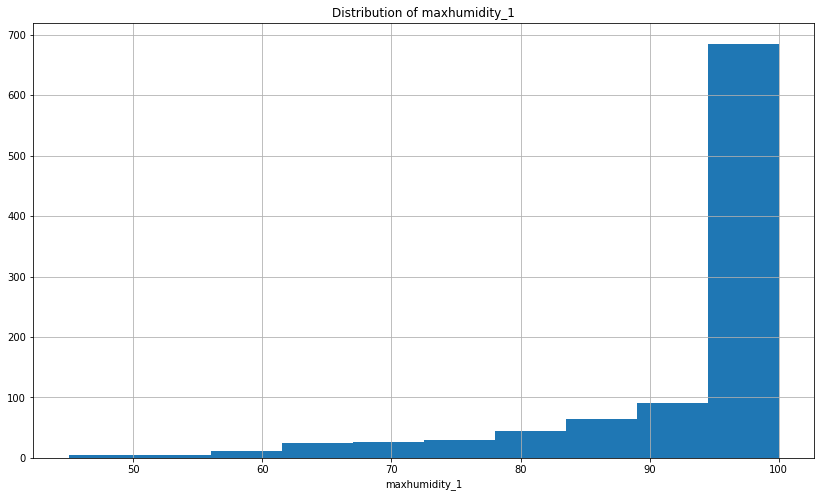

In [24]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.hist(df.maxhumidity_1)
ax.set_title('Distribution of maxhumidity_1')
ax.set_xlabel('maxhumidity_1')
ax.grid()

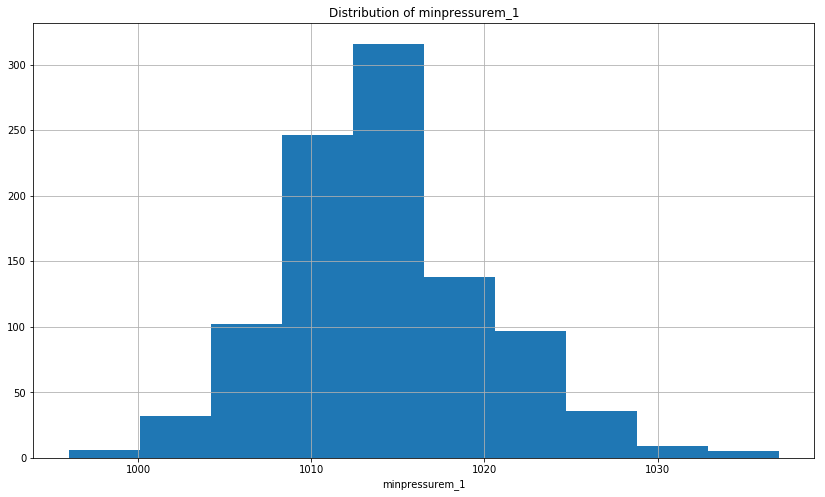

In [25]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.hist(df.minpressurem_1)
ax.set_title('Distribution of minpressurem_1')
ax.set_xlabel('minpressurem_1')
ax.grid()

In [26]:
# import pickle
with open('end-part1_df.pkl', 'wb') as f:
    pickle.dump(df, f)